In [9]:
import math
import numpy as np
np.set_printoptions(suppress=True,
        formatter={'all': lambda x: '%7.6f' % x})
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
import scipy.interpolate as sci
from scipy.optimize import fmin
from CIR_zcb_valuation_gen import B

In [10]:
#
# Market Data: Eonia rate (01.10.2014) + Euribor rates
# Source: http://www.emmi-benchmarks.eu
# on 30. September 2014
#

t_list = np.array((7, 30, 90, 180, 360)) / 360 
r_list =  np.array((3.802, 3.873, 3.825, 3.795, 3.696)) / 100

factors = (1 + t_list * r_list)
zero_rates = 1 / t_list * np.log(factors)

r0 = r_list[0] # 0.0  # set to zero 

In [13]:
#
# Interpolation of Market Data
#

tck = sci.splrep(t_list, zero_rates, k=3)  # cubic splines
tn_list = np.linspace(0.0, 1.0, 24)
ts_list = sci.splev(tn_list, tck, der=0)
de_list = sci.splev(tn_list, tck, der=1)

f = ts_list + de_list * tn_list
  # forward rate transformation

Text(0, 0.5, 'rate')

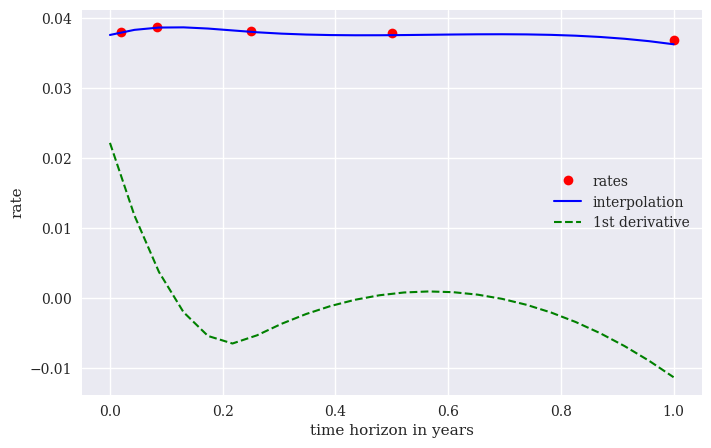

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(t_list, r_list, 'ro', label='rates')
plt.plot(tn_list, ts_list, 'b', label='interpolation', lw=1.5)
  # cubic splines
plt.plot(tn_list, de_list, 'g--', label='1st derivative', lw=1.5) 
  # first derivative
plt.legend(loc=0)
plt.xlabel('time horizon in years')
plt.ylabel('rate')

In [17]:
def CIR_forward_rate(opt):
    kappa_r, theta_r, sigma_r = opt
    t = tn_list
    g = np.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)
    sum1 = ((kappa_r * theta_r * (np.exp(g * t) - 1)) /
          (2 * g + (kappa_r + g) * (np.exp(g * t) - 1)))
    sum2 = r0 * ((4 * g ** 2 * np.exp(g * t)) /
            (2 * g + (kappa_r + g) * (np.exp(g * t) - 1)) ** 2)
    forward_rate = sum1 + sum2
    return forward_rate

In [19]:
def CIR_error_function(opt):
    ''' Error function for CIR85 model calibration. '''
    kappa_r, theta_r, sigma_r = opt
    if 2 * kappa_r * theta_r < sigma_r ** 2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100
    forward_rates = CIR_forward_rate(opt)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)
    # print opt, MSE
    return MSE

In [21]:
def CIR_calibration():
    opt = fmin(CIR_error_function, [1.0, 0.02, 0.1],
            xtol=0.00001, ftol=0.00001,
            maxiter=300, maxfun=500)
    return opt

In [23]:
opt = CIR_calibration()
opt

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 99
         Function evaluations: 181


array([0.222562, 0.030326, 0.116184])

In [25]:
def plot_calibrated_frc(opt):
    ''' Plots market and calibrated forward rate curves. '''
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(8, 7))
    plt.subplot(211)
    plt.ylabel('forward rate $f(0,T)$')
    plt.plot(tn_list, f, 'b', label='market')
    plt.plot(tn_list, forward_rates, 'ro', label='model')
    plt.legend(loc=0)
    plt.axis([min(tn_list) - 0.05, max(tn_list) + 0.05,
          min(f) - 0.005, max(f) * 1.1])
    plt.subplot(212)
    wi = 0.02
    plt.bar(tn_list, forward_rates - f, width=wi)
    plt.xlabel('time horizon in years')
    plt.ylabel('difference')
    plt.axis([min(tn_list) - 0.05, max(tn_list) + 0.05,
          min(forward_rates - f) * 1.1, max(forward_rates - f) * 1.1])
    plt.tight_layout()

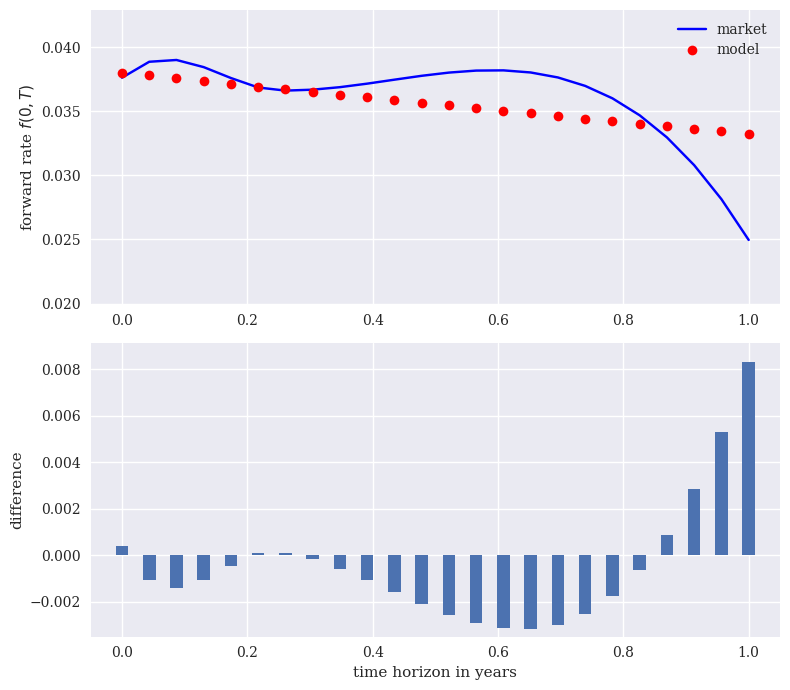

In [27]:
plot_calibrated_frc(opt)

In [29]:
def plot_zcb_values(p0, T):
    ''' Plots unit zero-coupon bond values (discount factors). '''
    t_list = np.linspace(0.0, T, 20)
    r_list = B([r0, p0[0], p0[1], p0[2], t_list, T])
    plt.figure(figsize=(8, 5))
    plt.plot(t_list, r_list, 'b')
    plt.plot(t_list, r_list, 'ro')
    plt.xlabel('time horizon in years')
    plt.ylabel('unit zero-coupon bond value')

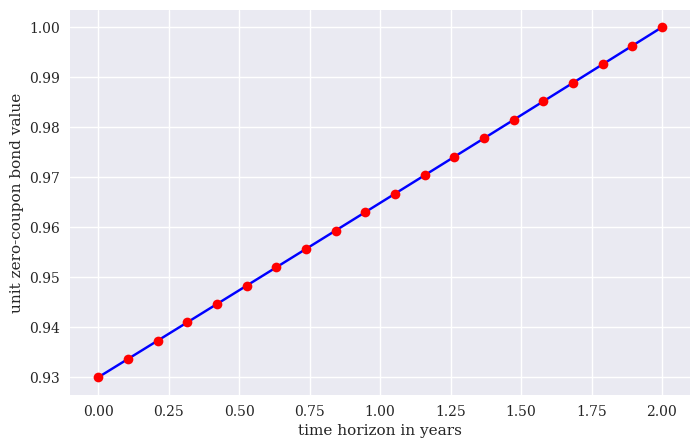

In [31]:
plot_zcb_values(opt, 2)

Calibration of the Equity Component

H93 Calibration

In [35]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import brute, fmin, minimize
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
from BCC_option_valuation import H93_call_value, BCC_call_value
from CIR_calibration import CIR_calibration, r_list
from CIR_zcb_valuation import B

In [37]:
#
# Calibrate Short Rate Model
#
kappa_r, theta_r, sigma_r = CIR_calibration()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 270
         Function evaluations: 485


In [39]:
kappa_r, theta_r, sigma_r

(0.1468490095575928, 0.1045105366734434, 0.17519710713793513)

In [41]:
Start = pd.Timestamp('2020-05-15')
End =  pd.Timestamp('2020-06-19')

S0 = 10337.02                     # Dax Index level
r = 0.0362                        # Assumption (Base Rate GER)

df = pd.read_csv('ref_eikon_option_data_adj_II.csv', index_col=0).dropna()
df.info()

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Maturity'] = pd.to_datetime(df['Maturity'], dayfirst=True)

<class 'pandas.core.frame.DataFrame'>
Index: 378 entries, 1 to 378
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Instrument  378 non-null    object 
 1   Date        378 non-null    object 
 2   Maturity    378 non-null    object 
 3   PUTCALLIND  378 non-null    object 
 4   Strike      378 non-null    int64  
 5   Close       378 non-null    float64
 6   Imp_Vol     378 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 23.6+ KB


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 378 entries, 1 to 378
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Instrument  378 non-null    object        
 1   Date        378 non-null    datetime64[ns]
 2   Maturity    378 non-null    datetime64[ns]
 3   PUTCALLIND  378 non-null    object        
 4   Strike      378 non-null    int64         
 5   Close       378 non-null    float64       
 6   Imp_Vol     378 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 23.6+ KB


In [45]:
df.head()

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol
1,/GDAX20000F0.EX,2020-05-15,2020-06-19,CALL,2000,8323.3,203.25
2,/GDAX20000R0.EX,2020-05-15,2020-06-19,PUT,2000,0.1,150.50
3,/GDAX36000F0.EX,2020-05-15,2020-06-19,CALL,3600,6722.5,130.77
4,/GDAX36000R0.EX,2020-05-15,2020-06-19,PUT,3600,0.4,102.66
5,/GDAX40000F0.EX,2020-05-15,2020-06-19,CALL,4000,6322.5,118.17


In [47]:
df.tail()

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol
374,/GDAX180000R0.EX,2020-05-15,2020-06-19,PUT,18000,7689.0,65.37
375,/GDAX185000F0.EX,2020-05-15,2020-06-19,CALL,18500,0.1,51.70
376,/GDAX185000R0.EX,2020-05-15,2020-06-19,PUT,18500,8189.4,68.53
377,/GDAX190000F0.EX,2020-05-15,2020-06-19,CALL,19000,0.1,53.91
378,/GDAX190000R0.EX,2020-05-15,2020-06-19,PUT,19000,8689.8,71.82


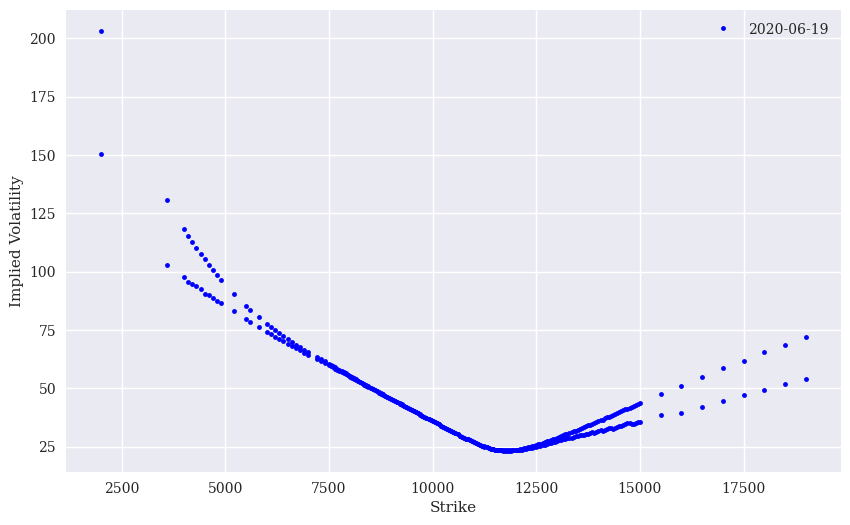

In [49]:
# Implied Volas from DAX Index Base Data ---------------------------------- # 


markers = ['.', 'o', '^', 'v', 'x', 'D', 'd', '>', '<']


def plot_imp_vols(data):
    ''' Plot the implied volatilites. '''
    maturities = sorted(set(data['Maturity']))
    plt.figure(figsize=(10, 6))
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0)]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'b%s' % markers[i], label=str(mat)[:10])
    plt.grid(True)
    plt.legend()
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.show()


plot_imp_vols(df)

In [51]:
# Separation of Piuts & Call in Imp Vola Plot ---------------------------- #


def plot_imp_vols_sep(data):
    ''' Plot the implied volatilites. '''
    maturities = sorted(set(data['Maturity']))
    plt.figure(figsize=(10, 6))
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0) & (data['PUTCALLIND'] == 'CALL')]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'r%s' % markers[i], label=str('CALLS')[:10])
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0) & (data['PUTCALLIND'] == 'PUT ')]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'b%s' % markers[i], label=str('PUTS')[:10])
    plt.grid(True)
    plt.legend()
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.show()

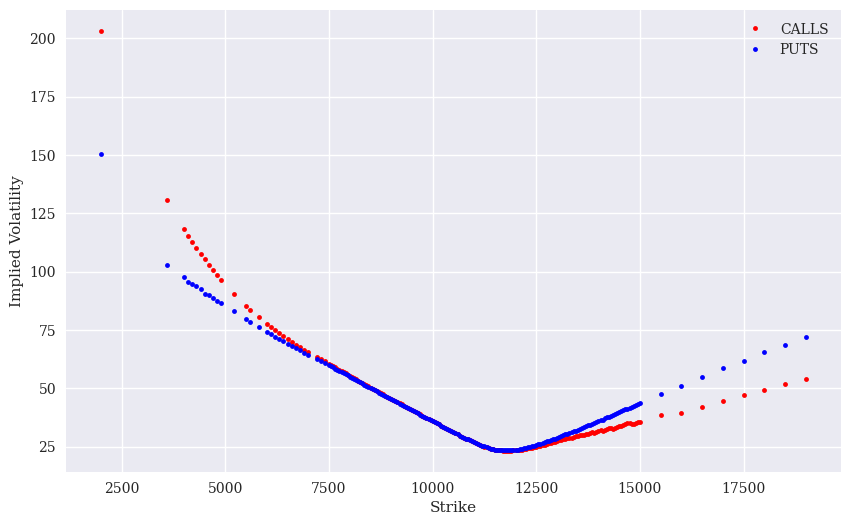

In [53]:
plot_imp_vols_sep(df)

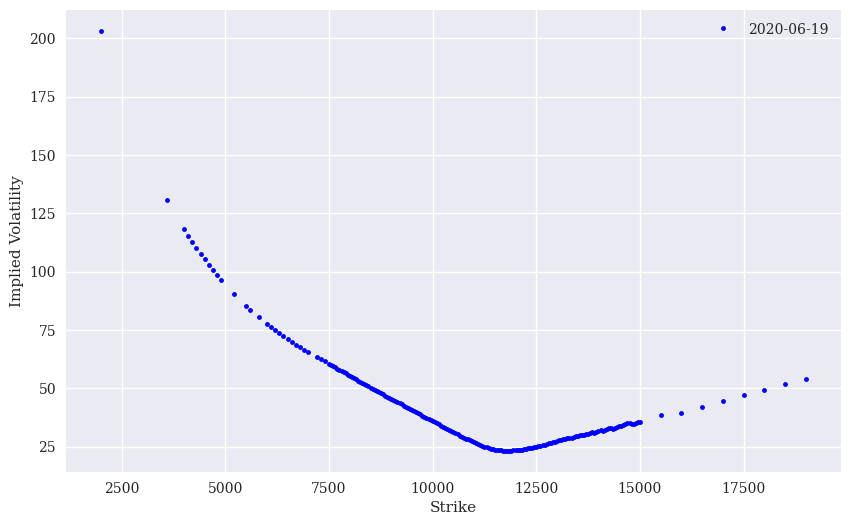

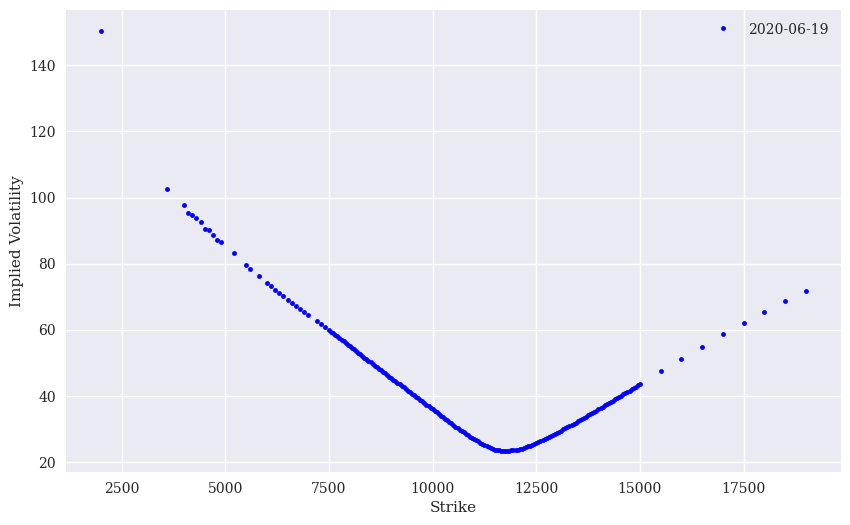

In [59]:
Calls = df['PUTCALLIND'] == 'CALL'
Puts = df['PUTCALLIND'] == 'PUT '

df_call = df[~Puts]
df_put = df[~Calls]

plot_imp_vols(df_call)
plot_imp_vols(df_put)

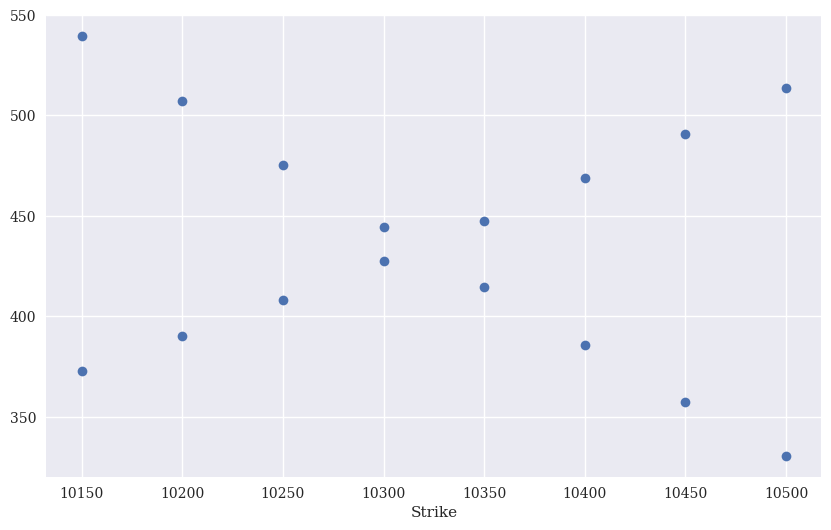

In [63]:
# Option Selection (from Calls & Puts)
tol = 0.02
options = df[(np.abs(df['Strike'] - S0) / S0) < tol]
mats = sorted(set(options['Maturity']))
options = options[options['Maturity'] == mats[0]]
options

options.set_index('Strike')['Close'].plot(style='o', figsize=(10, 6));

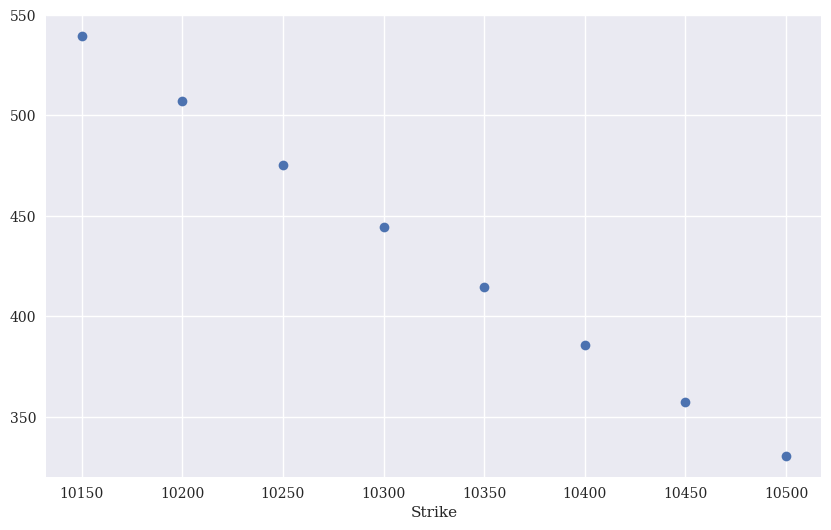

In [258]:
# Option Selection (from Calls only)
tol = 0.02
options_call = df_call[(np.abs(df_call['Strike'] - S0) / S0) < tol]
mats = sorted(set(options_call['Maturity']))
options_call = options_call[options_call['Maturity'] == mats[0]]
options_call

options_call.set_index('Strike')['Close'].plot(style='o', figsize=(10, 6));

Adjustment to base data in light of Code to follow

In [260]:
options = options_call

In [262]:
# Adding Time-to-Maturity and Short Rates 
#

for row, option in options.iterrows():
    T = (option['Maturity'] - option['Date']).days / 365.
    options.loc[row, 'T'] = T
    B0T = B([kappa_r, theta_r, sigma_r, r0, T])
    options.loc[row, 'r'] = -math.log(B0T) / T

options

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,T,r
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,34.49,0.09589,0.038484
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,34.02,0.09589,0.038484
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,33.53,0.09589,0.038484
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,33.06,0.09589,0.038484
175,/GDAX103500F0.EX,2020-05-15,2020-06-19,CALL,10350,414.5,32.57,0.09589,0.038484
177,/GDAX104000F0.EX,2020-05-15,2020-06-19,CALL,10400,385.5,32.11,0.09589,0.038484
179,/GDAX104500F0.EX,2020-05-15,2020-06-19,CALL,10450,357.4,31.62,0.09589,0.038484
181,/GDAX105000F0.EX,2020-05-15,2020-06-19,CALL,10500,330.5,31.16,0.09589,0.038484


In [318]:
i = 0
min_MSE = 500
def H93_error_function(p0):
    np.set_printoptions(suppress=True,
            formatter={'all': lambda x: '%5.3f' % x})
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0 
    if kappa_v < 0.0 or kappa_v > 90.0 or theta_v < 0.005 or sigma_v < 0.0 or \
                rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v ** 2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                            option['r'], kappa_v, theta_v, sigma_v, rho, v0)
        se.append((model_value - option['Close']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 50 == 0:
        print('%4d |' % i, np.array(p0), '| %8.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE

In [320]:
def H93_calibration_full():
    # first run with brute force
    # (scan sensible regions)
    p0 = brute(H93_error_function,
                ((25.0, 50.0, 5.0),               # kappa_v
                (0.01, 0.041, 0.01),              # theta_v
                (0.05, 0.251, 0.1),               # sigma_v
                (-0.75, 0.01, 0.75),              # rho
                (0.01, 0.031, 0.01)),             # v0
                finish=None)

    # second run with local, convex minimization
    # (dig deeper where promising)
    opt = fmin(H93_error_function, p0,  
                 xtol=0.000001, ftol=0.000001,
                 maxiter=750, maxfun=900)
    np.save('opt_sv_DAX', np.array(opt))
    return opt

In [322]:
%time opt = H93_calibration_full()

   0 | [25.000 0.010 0.050 -0.750 0.010] | 72809.351 | 500.000
  50 | [25.000 0.030 0.250 -0.750 0.030] | 32654.400 | 500.000
 100 | [30.000 0.020 0.150 0.000 0.020] | 48465.734 | 500.000
 150 | [35.000 0.010 0.150 -0.750 0.010] | 72728.330 | 500.000
 200 | [35.000 0.040 0.050 -0.750 0.030] | 24515.078 | 500.000
 250 | [40.000 0.020 0.250 0.000 0.020] | 48517.205 | 500.000
 300 | [45.000 0.010 0.250 -0.750 0.010] | 72725.386 | 500.000
 350 | [45.000 0.040 0.150 -0.750 0.030] | 23905.440 | 500.000
 400 | [34.617 0.118 0.081 0.460 0.077] |  256.332 | 179.706
 450 | [35.225 0.111 0.100 0.338 0.072] |  135.166 | 134.696
 500 | [35.006 0.112 0.099 0.341 0.072] |  134.578 | 134.578
 550 | [28.157 0.116 0.053 0.096 0.071] |  131.715 | 131.405
 600 | [23.072 0.121 0.017 -0.062 0.070] |  130.904 | 130.904
 650 | [23.153 0.121 0.018 -0.066 0.070] |  130.878 | 130.878
 700 | [38.487 0.117 0.291 -0.612 0.049] |  123.356 | 123.356
 750 | [41.285 0.121 0.392 -0.994 0.039] |   98.144 |  97.878
 800 |

In [324]:
opt

array([90.000, 0.113, 1.027, -1.000, 0.010])

In [326]:
# Calibration of the Jump Component --------------------------------------- #

#
# Option Selection
#
mats = sorted(set(options['Maturity']))
optionss = options[options['Maturity'] == mats[0]]
  # only shortest maturity

#
# Initial Parameter Guesses
#
kappa_v, theta_v, sigma_v, rho, v0 = np.load('opt_sv_DAX.npy')
    # from H93 model calibration

In [328]:
i = 0
min_MSE = 5000.0
local_opt = False
def BCC_error_function(p0):
    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in optionss.iterrows():
        model_value = BCC_call_value(S0, option['Strike'], option['T'],
                            option['r'], kappa_v, theta_v, sigma_v, rho, v0,
                            lamb, mu, delta)
        se.append((model_value - option['Close']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [336]:
def BCC_calibration_short():
    # first run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(BCC_error_function,
                ((0.0, 0.51, 0.1),  # lambda
                (-0.5, -0.11, 0.1), # mu
                (0.0, 0.51, 0.25)), # delta
                finish=None)

    # second run with local, convex minimization
    # (dig deeper where promising)
    local_opt = True
    opt2 = fmin(BCC_error_function, opt1,
                xtol=0.0000001, ftol=0.0000001,
                maxiter=550, maxfun=750)
    np.save('opt_jump_DAX', np.array(opt2))
    return opt2

In [338]:
%time opt2 = BCC_calibration_short()

 300 | [0.100 -0.200 0.500] | 328.939 |  83.894
 325 | [0.400 -0.500 0.000] | 5303.118 |  83.894
 350 | [0.000 -0.500 0.000] |  84.387 |  83.894
 375 | [0.005 -0.384 0.000] |  83.976 |  83.894
 400 | [0.004 -0.595 0.001] |  83.895 |  83.894
 425 | [0.004 -0.600 0.001] |  83.894 |  83.894
 450 | [0.004 -0.600 0.001] |  83.894 |  83.894
 475 | [0.004 -0.600 0.000] |  83.894 |  83.894
 500 | [0.004 -0.600 0.000] |  83.894 |  83.894
 525 | [0.004 -0.600 0.000] |  83.894 |  83.894
 550 | [0.004 -0.600 0.000] |  83.894 |  83.894
Optimization terminated successfully.
         Current function value: 83.893689
         Iterations: 161
         Function evaluations: 305
CPU times: total: 6.23 s
Wall time: 17.5 s


In [340]:
opt2

array([0.004, -0.600, 0.000])

In [342]:
# Final and Full Calibration of the Model - BCC -------------------------- #

#
# Parameters from H93 & jump calibrations
#
kappa_v, theta_v, sigma_v, rho, v0 = np.load('opt_sv_DAX.npy')
lamb, mu, delta = np.load('opt_jump_DAX.npy')
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [344]:
def BCC_error_function(p0):
    np.set_printoptions(suppress=True,
            formatter={'all': lambda x: '%5.3f' % x})
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0 
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or \
        rho < -1.0 or rho > 1.0 or v0 < 0.0 or lamb < 0.0 or \
        mu < -.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    if 2 * kappa_v * theta_v < sigma_v ** 2:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = BCC_call_value(S0, option['Strike'], option['T'],
                            option['r'], kappa_v, theta_v, sigma_v, rho, v0,
                            lamb, mu, delta)
        se.append((model_value - option['Close']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE

In [348]:
def BCC_calibration_full():
    # local, convex minimization for all parameters
    opt = fmin(BCC_error_function, p0,  
                 xtol=0.000001, ftol=0.000001,
                 maxiter=450, maxfun=650)
    np.save('opt_full_DAX', np.array(opt))
    return opt

In [350]:
%time opt3 = BCC_calibration_full()

 575 | [90.000 0.113 1.072 -1.000 0.010 0.004 -0.600 0.000] |  81.997 |  81.729
 600 | [90.000 0.113 1.078 -1.000 0.010 0.004 -0.600 0.000] |  81.747 |  81.729
 625 | [90.002 0.113 1.079 -1.000 0.010 0.004 -0.600 0.000] |  81.731 |  81.729
 650 | [90.000 0.113 1.079 -1.000 0.010 0.004 -0.600 0.000] |  81.729 |  81.729
 675 | [90.000 0.113 1.079 -1.000 0.010 0.004 -0.600 0.000] |  81.729 |  81.729
 700 | [90.000 0.113 1.079 -1.000 0.010 0.004 -0.600 0.000] |  81.729 |  81.729
Optimization terminated successfully.
         Current function value: 81.728656
         Iterations: 27
         Function evaluations: 251
CPU times: total: 3.8 s
Wall time: 9.21 s


In [352]:
def BCC_calculate_model_values(p0):
    ''' Calculates all model values given parameter vector p0. '''
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0  
    values = []
    for row, option in options.iterrows():
        model_value = BCC_call_value(S0, option['Strike'], option['T'],
                            option['r'], kappa_v, theta_v, sigma_v, rho, v0,
                            lamb, mu, delta)
        values.append(model_value)
    return np.array(values)
options['Model'] = BCC_calculate_model_values(opt3)

Text(0, 0.5, 'option values')

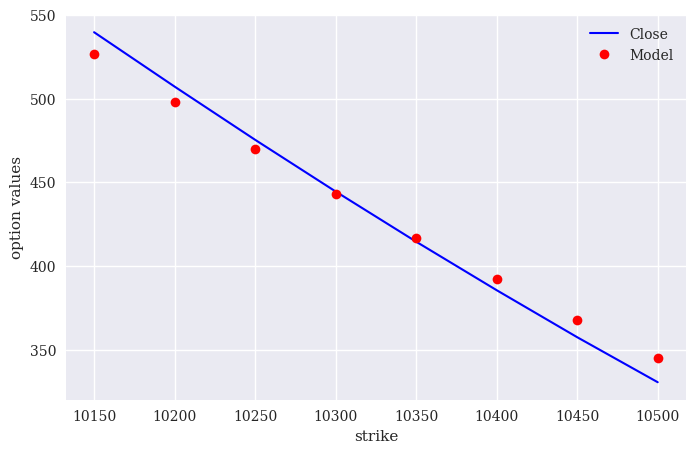

In [356]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for mat in set(options['Maturity']):
    options[options.Maturity == mat].plot(x='Strike', y='Close',
                                          style='b', lw=1.5,
                                          legend=True, ax=ax)
    options[options.Maturity == mat].plot(x='Strike', y='Model',
                                          style='ro', legend=True,
                                          ax=ax)
plt.xlabel('strike')
plt.ylabel('option values')

In [392]:
# Subplots incl Delta View on Option Prices Comparison - Market vs Model


def plot_market_model_valuation(options, model):
    ''' Plots market implied volatilities against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('Option prices')
        plt.plot(opts.Strike, opts.Close, 'b', label='market', lw=1.5)
        plt.plot(opts.Strike, opts.Model, 'ro', label='model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
              min(opts.Close) - 20, max(opts.Close) + 20])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.Close.values - opts.Model.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('Valuation_DAX_BCC97.png')

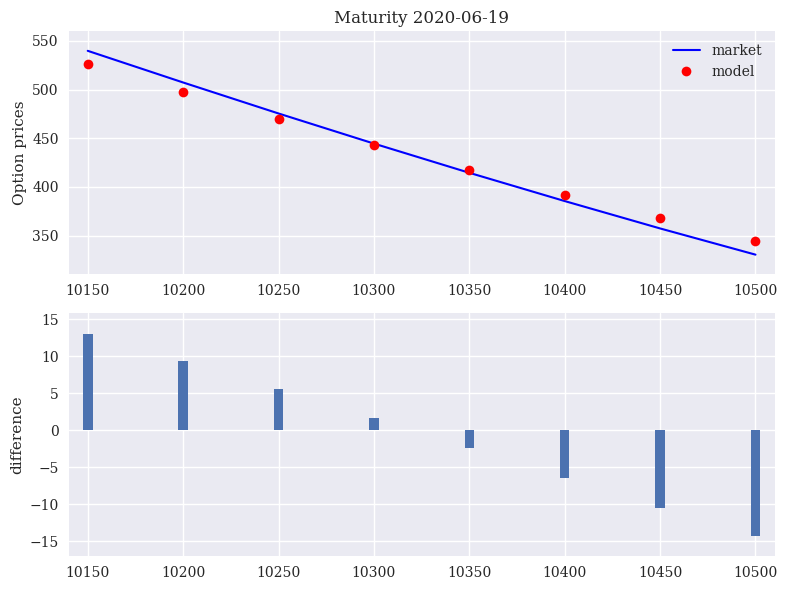

In [394]:
plot_market_model_valuation(options, 'BCC97')

In [422]:
filename = 'cal_results_full_DAX.h5'
h5 = pd.HDFStore(filename, 'w')
h5['options'] = options
h5.close()

In [424]:
from BSM_imp_vol import call_option
def calculate_implied_volatilities(filename):
    ''' Calculates market and model implied volatilities. '''
    h5 = pd.HDFStore(filename, 'r')
    options = h5['options']
    h5.close()
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        B0T = B([kappa_r, theta_r, sigma_r, r0, T])
        r = -math.log(B0T) / T
        call = call_option(S0, option['Strike'], option['Date'],
                            option['Maturity'], option['r'], 0.1)
        options.loc[row, 'market_iv'] = call.imp_vol(option['Close'], 0.15)
        options.loc[row, 'model_iv'] = call.imp_vol(option['Model'], 0.15)
    return options

In [426]:
options = calculate_implied_volatilities('cal_results_full_DAX.h5')
options

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,T,r,Model,market_iv,model_iv
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,34.49,0.09589,0.038484,526.670828,0.331034,0.320458
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,34.02,0.09589,0.038484,497.794174,0.327152,0.319606
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,33.53,0.09589,0.038484,469.875177,0.323147,0.318756
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,33.06,0.09589,0.038484,442.921299,0.319156,0.317910
175,/GDAX103500F0.EX,2020-05-15,2020-06-19,CALL,10350,414.5,32.57,0.09589,0.038484,416.937757,0.315153,0.317067
177,/GDAX104000F0.EX,2020-05-15,2020-06-19,CALL,10400,385.5,32.11,0.09589,0.038484,391.927496,0.311192,0.316227
179,/GDAX104500F0.EX,2020-05-15,2020-06-19,CALL,10450,357.4,31.62,0.09589,0.038484,367.891154,0.307171,0.315389
181,/GDAX105000F0.EX,2020-05-15,2020-06-19,CALL,10500,330.5,31.16,0.09589,0.038484,344.827063,0.303302,0.314555


<Axes: xlabel='Strike'>

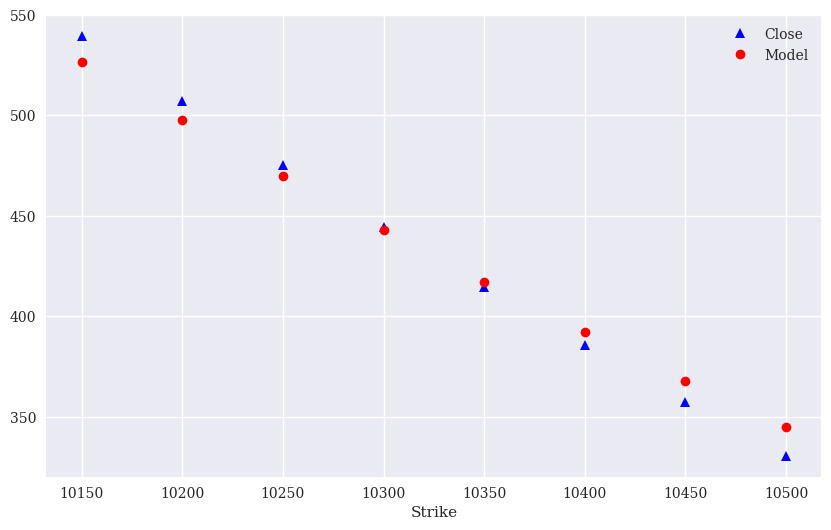

In [428]:
options.set_index('Strike')[['Close', 'Model']].plot(figsize=(10,6), style=['b^', 'ro'])

In [430]:
def plot_implied_volatilities(options, model):
    ''' Plots market implied volatilities against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('implied volatility')
        plt.plot(opts.Strike, opts.market_iv, 'b', label='market', lw=1.5)
        plt.plot(opts.Strike, opts.model_iv, 'ro', label='model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
              min(opts.market_iv) - 0.005, max(opts.market_iv) + 0.005])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.model_iv.values - opts.market_iv.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('Imp_Volas_DAX_BCC97.png')

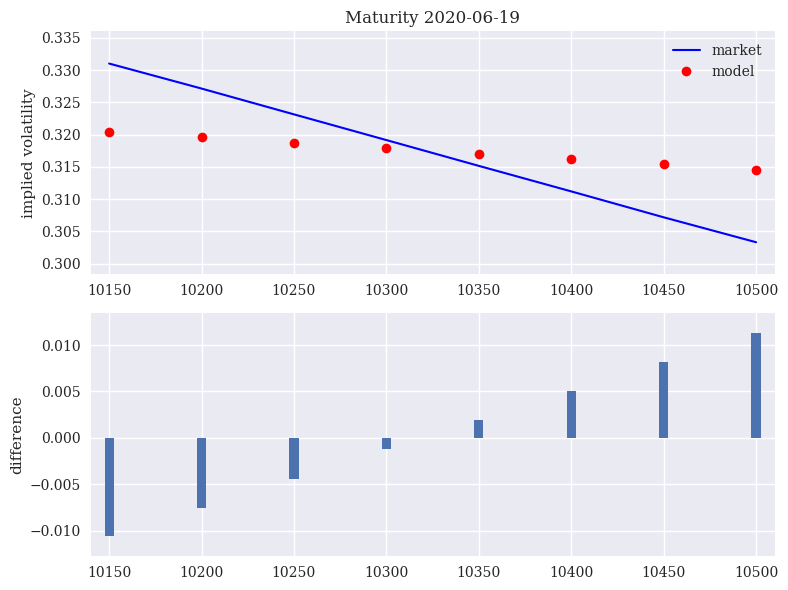

In [432]:
plot_implied_volatilities(options, 'BCC97')

<span style="font-size:30px;">Reduced selection of price points for calibration</span>

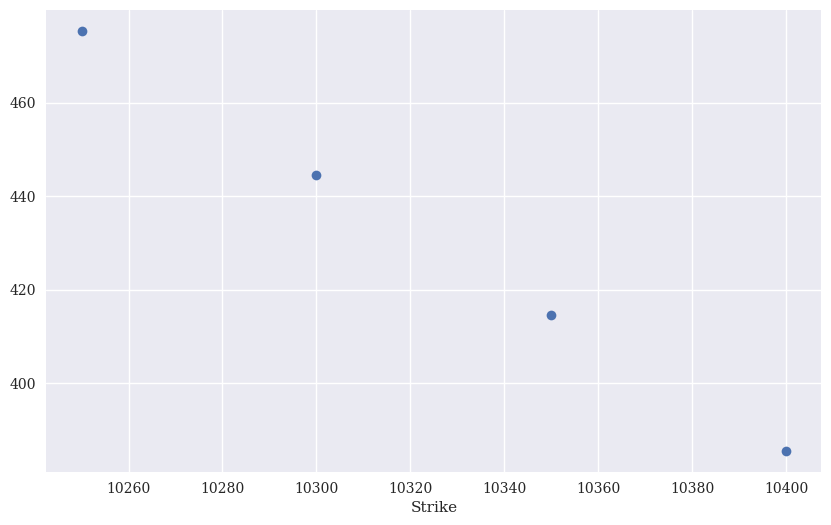

In [458]:
# Option Selection (from Calls only)
tol = 0.01
options_call_short = df_call[(np.abs(df_call['Strike'] - S0) / S0) < tol]
mats = sorted(set(options_call_short['Maturity']))
options_call_short = options_call_short[options_call_short['Maturity'] == mats[0]]
options_call_short

options_call_short.set_index('Strike')['Close'].plot(style='o', figsize=(10, 6));

Adjustment to base data in light of code to follow

In [462]:
options = options_call_short

In [464]:
# Adding Time-to-Maturity and Short Rates 
#

for row, option in options.iterrows():
    T = (option['Maturity'] - option['Date']).days / 365.
    options.loc[row, 'T'] = T
    B0T = B([kappa_r, theta_r, sigma_r, r0, T])
    options.loc[row, 'r'] = -math.log(B0T) / T

options

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,T,r
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,33.53,0.09589,0.038484
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,33.06,0.09589,0.038484
175,/GDAX103500F0.EX,2020-05-15,2020-06-19,CALL,10350,414.5,32.57,0.09589,0.038484
177,/GDAX104000F0.EX,2020-05-15,2020-06-19,CALL,10400,385.5,32.11,0.09589,0.038484


Error function of the H93 Model

In [476]:
i = 0
min_MSE = 500
def H93_error_function(p0):
    np.set_printoptions(suppress=True,
            formatter={'all': lambda x: '%5.3f' % x})
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0 
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or \
                rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v ** 2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                            option['r'], kappa_v, theta_v, sigma_v, rho, v0)
        se.append((model_value - option['Close']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 50 == 0:
        print('%4d |' % i, np.array(p0), '| %8.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE

In [485]:
def H93_calibration_full():
    # first run with brute force
    # (scan sensible regions)
    p0 = brute(H93_error_function,
                ((25, 50, 5.0),  # kappa_v
                (0.01, 0.041, 0.01),  # theta_v
                (0.05, 0.251, 0.1),  # sigma_v
                (-0.75, 0.01, 0.25),  # rho
                (0.01, 0.031, 0.01)),  # v0
                finish=None)

    # second run with local, convex minimization
    # (dig deeper where promising)
    opt = fmin(H93_error_function, p0,  
                 xtol=0.000001, ftol=0.000001,
                 maxiter=750, maxfun=900)
    np.save('opt_sv_DAX_Short', np.array(opt))
    return opt

In [487]:
%time opt = H93_calibration_full()

 600 | [25.000 0.020 0.150 -0.750 0.010] | 57476.456 | 500.000
 650 | [25.000 0.030 0.250 -0.750 0.030] | 33219.224 | 500.000
 700 | [30.000 0.010 0.050 -0.500 0.020] | 65040.624 | 500.000
 750 | [30.000 0.020 0.150 -0.250 0.010] | 56430.708 | 500.000
 800 | [30.000 0.030 0.250 -0.250 0.030] | 33312.048 | 500.000
 850 | [35.000 0.010 0.050 0.000 0.020] | 66239.181 | 500.000
 900 | [35.000 0.020 0.250 -0.750 0.010] | 55378.507 | 500.000
 950 | [35.000 0.040 0.050 -0.750 0.030] | 24872.725 | 500.000
1000 | [40.000 0.010 0.150 -0.500 0.020] | 67053.619 | 500.000
1050 | [40.000 0.020 0.250 -0.250 0.010] | 54816.284 | 500.000
1100 | [40.000 0.040 0.050 -0.250 0.030] | 24555.155 | 500.000
1150 | [45.000 0.010 0.150 0.000 0.020] | 67982.396 | 500.000
1200 | [45.000 0.030 0.050 -0.750 0.010] | 39839.477 | 500.000
1250 | [45.000 0.040 0.150 -0.750 0.030] | 24253.570 | 500.000
1300 | [36.786 0.084 0.062 -0.113 0.056] | 2759.914 | 500.000
1350 | [34.716 0.113 0.017 0.359 0.072] |   33.687 |  32.3

Calibration of Jump Component

In [491]:
#
# Option Selection
#
mats = sorted(set(options['Maturity']))
optionss = options[options['Maturity'] == mats[0]]
  # only shortest maturity

#
# Initial Parameter Guesses
#
kappa_v, theta_v, sigma_v, rho, v0 = np.load('opt_sv_DAX_Short.npy')
    # from H93 model calibration

In [495]:
i = 0
min_MSE = 5000.0
local_opt = False
def BCC_error_function(p0):
    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in optionss.iterrows():
        model_value = BCC_call_value(S0, option['Strike'], option['T'],
                            option['r'], kappa_v, theta_v, sigma_v, rho, v0,
                            lamb, mu, delta)
        se.append((model_value - option['Close']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [497]:
def BCC_calibration_short():
    # first run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(BCC_error_function,
                ((0.0, 0.51, 0.1),  # lambda
                (-0.5, -0.11, 0.1), # mu
                (0.0, 0.51, 0.25)), # delta
                finish=None)

    # second run with local, convex minimization
    # (dig deeper where promising)
    local_opt = True
    opt2 = fmin(BCC_error_function, opt1,
                xtol=0.0000001, ftol=0.0000001,
                maxiter=550, maxfun=750)
    np.save('opt_jump_DAX_Short', np.array(opt2))
    return opt2

In [499]:
%time opt2 = BCC_calibration_short()

   0 | [0.000 -0.500 0.000] |  31.812 |  31.812
  25 | [0.200 -0.500 0.250] | 1116.898 |  31.812
  50 | [0.400 -0.500 0.500] | 5549.024 |  31.812
  75 | [0.000 -0.500 0.000] |  31.812 |  31.803
 100 | [0.001 -0.561 0.000] |  31.885 |  31.796
 125 | [0.001 -0.539 0.000] |  31.796 |  31.796
 150 | [0.001 -0.542 0.000] |  31.796 |  31.796
 175 | [0.001 -0.542 0.000] |  31.885 |  31.796
 200 | [0.001 -0.542 0.000] |  31.796 |  31.796
 225 | [0.001 -0.542 0.000] |  31.885 |  31.796
 250 | [0.001 -0.542 0.000] |  31.796 |  31.796
 275 | [0.001 -0.542 0.000] |  31.796 |  31.796
Optimization terminated successfully.
         Current function value: 31.795804
         Iterations: 113
         Function evaluations: 217
CPU times: total: 22 s
Wall time: 37.4 s


In [501]:
#
# Parameters from H93 & jump calibrations
#
kappa_v, theta_v, sigma_v, rho, v0 = np.load('opt_sv_DAX_Short.npy')
lamb, mu, delta = np.load('opt_jump_DAX_Short.npy')
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [503]:
def BCC_error_function(p0):
    np.set_printoptions(suppress=True,
            formatter={'all': lambda x: '%5.3f' % x})
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0 
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or \
        rho < -1.0 or rho > 1.0 or v0 < 0.0 or lamb < 0.0 or \
        mu < -.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    if 2 * kappa_v * theta_v < sigma_v ** 2:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = BCC_call_value(S0, option['Strike'], option['T'],
                            option['r'], kappa_v, theta_v, sigma_v, rho, v0,
                            lamb, mu, delta)
        se.append((model_value - option['Close']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE

In [505]:
def BCC_calibration_full():
    # local, convex minimization for all parameters
    opt = fmin(BCC_error_function, p0,  
                 xtol=0.000001, ftol=0.000001,
                 maxiter=450, maxfun=650)
    np.save('opt_full_DAX_Short', np.array(opt))
    return opt

In [507]:
%time opt3 = BCC_calibration_full()

 300 | [34.386 0.112 0.000 0.289 0.068 0.001 -0.550 0.000] |  36.371 |  31.796
 325 | [33.916 0.113 0.000 0.290 0.071 0.001 -0.556 0.000] |  31.866 |  31.796
 350 | [33.903 0.113 0.000 0.287 0.071 0.001 -0.547 0.000] |  31.875 |  31.796
 375 | [33.887 0.113 0.000 0.285 0.072 0.001 -0.542 0.000] |  31.880 |  31.796
 400 | [33.894 0.113 0.000 0.285 0.072 0.001 -0.542 0.000] |  31.893 |  31.796
 425 | [33.896 0.113 0.000 0.285 0.072 0.001 -0.542 0.000] |  31.911 |  31.796
 450 | [33.896 0.113 0.000 0.285 0.072 0.001 -0.542 0.000] |  31.897 |  31.796
 475 | [33.897 0.113 0.000 0.285 0.072 0.001 -0.542 0.000] |  31.784 |  31.784
 500 | [33.897 0.113 0.000 0.285 0.072 0.001 -0.542 0.000] |  31.904 |  31.784
 525 | [33.897 0.113 0.000 0.285 0.072 0.001 -0.542 0.000] |  31.899 |  31.784
 550 | [33.897 0.113 0.000 0.285 0.072 0.001 -0.542 0.000] |  31.917 |  31.784
 575 | [33.897 0.113 0.000 0.285 0.072 0.001 -0.542 0.000] |  31.799 |  31.784
 600 | [33.897 0.113 0.000 0.285 0.072 0.001 -0.542 

In [509]:
def BCC_calculate_model_values(p0):
    ''' Calculates all model values given parameter vector p0. '''
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0  
    values = []
    for row, option in options.iterrows():
        model_value = BCC_call_value(S0, option['Strike'], option['T'],
                            option['r'], kappa_v, theta_v, sigma_v, rho, v0,
                            lamb, mu, delta)
        values.append(model_value)
    return np.array(values)
options['Model'] = BCC_calculate_model_values(opt3)

Text(0, 0.5, 'Option Values')

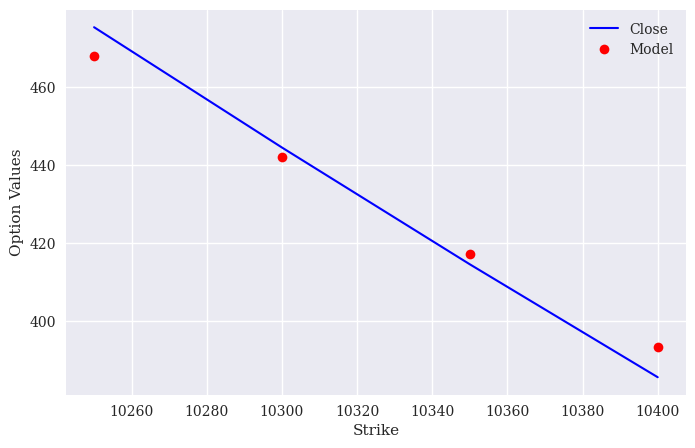

In [511]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for mat in set(options['Maturity']):
    options[options.Maturity == mat].plot(x='Strike', y='Close',
                                          style='b', lw=1.5,
                                          legend=True, ax=ax)
    options[options.Maturity == mat].plot(x='Strike', y='Model',
                                          style='ro', legend=True,
                                          ax=ax)
plt.xlabel('Strike')
plt.ylabel('Option Values')

In [513]:
filename = 'cal_results_full_DAX_Short.h5'
h5 = pd.HDFStore(filename, 'w')
h5['options'] = options
h5.close()

In [515]:
from BSM_imp_vol import call_option
def calculate_implied_volatilities(filename):
    ''' Calculates market and model implied volatilities. '''
    h5 = pd.HDFStore(filename, 'r')
    options = h5['options']
    h5.close()
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        B0T = B([kappa_r, theta_r, sigma_r, r0, T])
        r = -math.log(B0T) / T
        call = call_option(S0, option['Strike'], option['Date'],
                            option['Maturity'], option['r'], 0.1)
        options.loc[row, 'market_iv'] = call.imp_vol(option['Close'], 0.15)
        options.loc[row, 'model_iv'] = call.imp_vol(option['Model'], 0.15)
    return options

In [517]:
options = calculate_implied_volatilities('cal_results_full_DAX_Short.h5')
options

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,T,r,Model,market_iv,model_iv
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,33.53,0.09589,0.038484,468.110816,0.323147,0.317354
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,33.06,0.09589,0.038484,442.131249,0.319156,0.317287
175,/GDAX103500F0.EX,2020-05-15,2020-06-19,CALL,10350,414.5,32.57,0.09589,0.038484,417.212818,0.315153,0.317283
177,/GDAX104000F0.EX,2020-05-15,2020-06-19,CALL,10400,385.5,32.11,0.09589,0.038484,393.271596,0.311192,0.317280


In [519]:
def plot_implied_volatilities(options, model):
    ''' Plots market implied volatilities against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('Implied Volatility')
        plt.plot(opts.Strike, opts.market_iv, 'b', label='Market', lw=1.5)
        plt.plot(opts.Strike, opts.model_iv, 'ro', label='Model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
              min(opts.market_iv) - 0.015, max(opts.market_iv) + 0.015])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.model_iv.values - opts.market_iv.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()

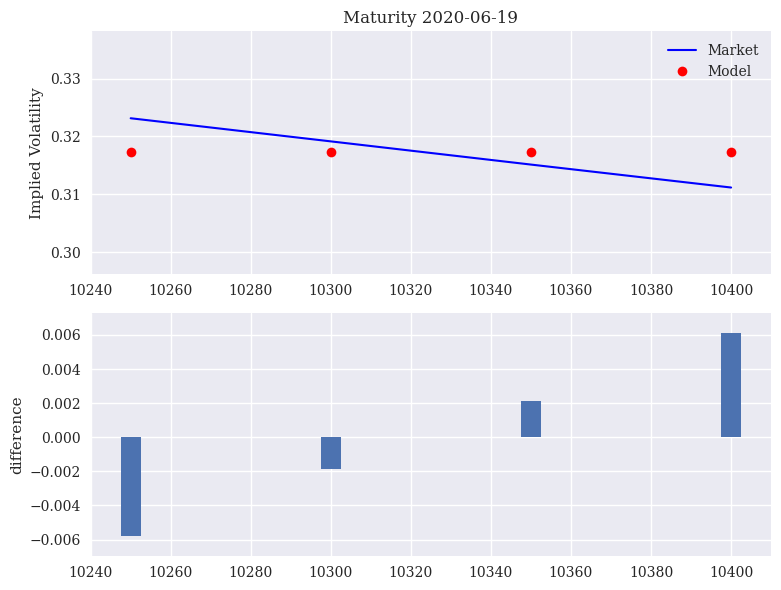

In [521]:
plot_implied_volatilities(options, 'BCC97')

In [523]:
# Subplots incl Delta View on Option Prices Comparison - Market vs Model


def plot_market_model_valuation(options, model):
    ''' Plots market prices against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('Option prices')
        plt.plot(opts.Strike, opts.Close, 'b', label='Market', lw=1.5)
        plt.plot(opts.Strike, opts.Model, 'ro', label='Model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
              min(opts.Close) - 20, max(opts.Close) + 20])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.Close.values - opts.Model.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('Difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('Valuation_DAX_BCC97_SHORT.png')

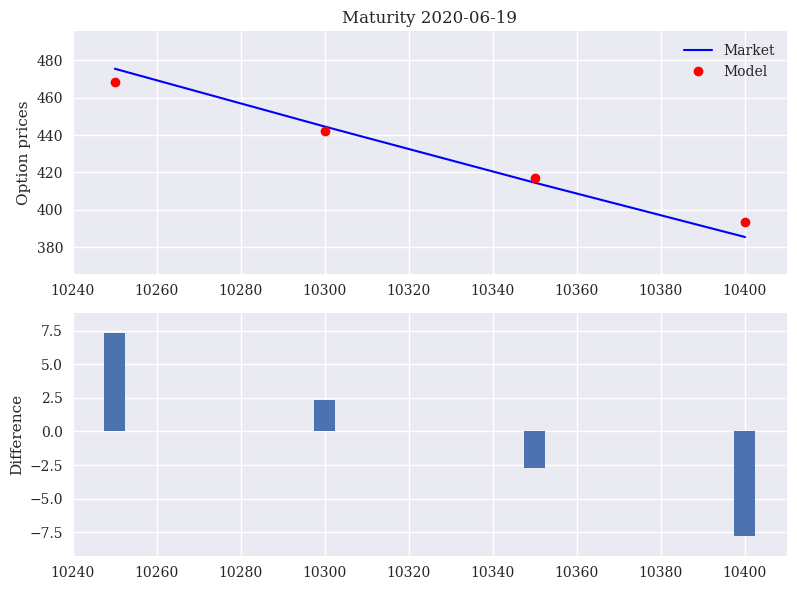

In [525]:
plot_market_model_valuation(options, 'BCC97')